In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Introducing the stars
import tensorflow as tf
from tensorflow import keras

In [ ]:
print(tf.__version__, keras.__version__)
print(tf.config.list_physical_devices())

# devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(devices[0], True)

2.8.0 2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


RuntimeError: Physical devices cannot be modified after being initialized

In [18]:
keras.backend.clear_session()

# Redes Neuronales Artificiales

Vamos a explorar algunos usos básicos del paquete `keras` para construir y entrenar RNAs.

Hay diferentes formas en las que `keras` puede construir modelos de RNA. En particular, veremos las APIs Secuencial y Funcional. Para las redes feed-forward totalmente conectadas, la API Secuencial es probablemente la más directa.

## MNIST a través de la lente de las RNAs

Vamos a reutilizar el conjunto de datos MNIST de números escritos a mano y a entrenar una red neuronal sencilla para clasificarlos.

El objetivo es entonces tratar de entender cómo funciona la red, por lo que vamos a elegir una arquitectura relativamente sencilla.

### Preparación de los datos

In [19]:
(X_train, t_train), (X_test, t_test) = keras.datasets.mnist.load_data()

In [20]:
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [21]:
t_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Las etiquetas de `t_train` y `t_test` son números entre 0 y 9.

Lo primero que hacemos es convertir las etiquetas de clase a la codificación 1-de-K. Para ello utilizamos la función `keras.utils.to_categorical` (similar al  `OneHotEncoder` de `sklearn`).

In [22]:
t_train_ohe = keras.utils.to_categorical(t_train)
t_test_ohe = keras.utils.to_categorical(t_test)
print(t_train_ohe[:3], t_train[:3])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


A continuación, normalizamos las imágenes. Llevamos la escala de píxeles, originalmente entre 0 y 255, al intervalo [0, 1).

In [23]:
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

X_train = X_train/255.0
X_test = X_test/255.0

print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

0 255
0 255
0.0 1.0
0.0 1.0


No hay mucho más que hacer en cuanto a la preparación de los datos, porque `keras` ya divide el conjunto en conjuntos de entrenamiento y de prueba (que usaremos como validación). 

Visualicemos simplemente a algunos individuos.

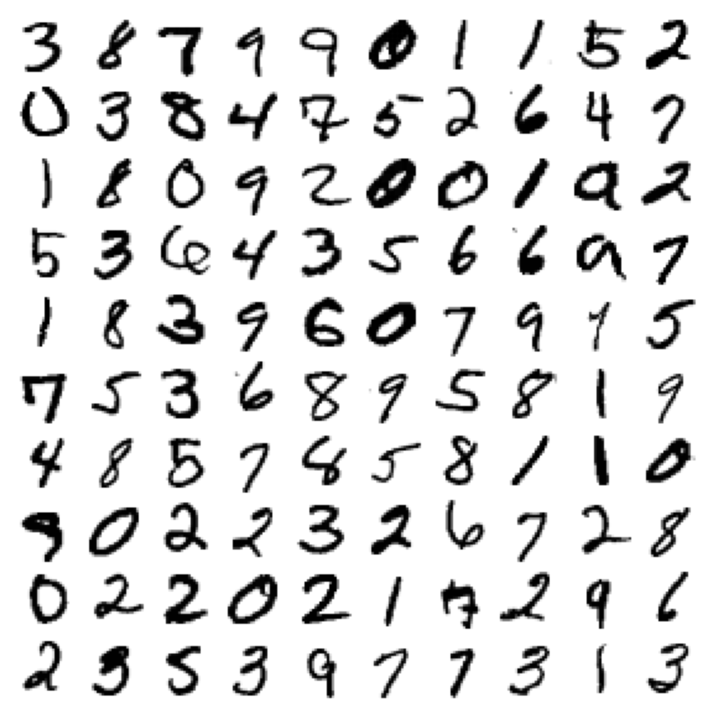

In [24]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap ='binary', **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
plot_digits(X_train[10000:10100], images_per_row=10)

### Definición del modelo.

¿Cómo empezamos a definir un modelo de este tipo? Tenemos que definir el número de capas, el número de unidades en cada capa, las funciones de activación, y varias cosas más.

Implemenemos una red similar, aunque más grande.

In [52]:
# Capa de entrada / Input Layer
input_ = keras.layers.Input(shape=list(X_train.shape[1:]) + [1])

# Primera y segunda capas convolucionales, con diferente relleno (padding)
conv1 = keras.layers.Conv2D(filters=12, kernel_size=(2, 2), padding='same', activation='relu')(input_)
conv2 = keras.layers.Conv2D(filters=24, kernel_size=(2, 2),  padding='valid',activation='relu')(conv1)

# Capa MaxPool 
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

# Dropout
dropout1 = keras.layers.Dropout(0.25)(pool1)

# Aplanado y totalmente conectado / Flatten and fully-connected 
flatten = keras.layers.Flatten()(dropout1)

hidden1 = keras.layers.Dense(128, activation="relu")(flatten)
dropout2 = keras.layers.Dropout(0.5)(hidden1)

# Capa de salida (usando softmax)
output = keras.layers.Dense(10, activation="softmax")(dropout2)

# Define el modelo
model = keras.models.Model(inputs=[input_], outputs=[output])

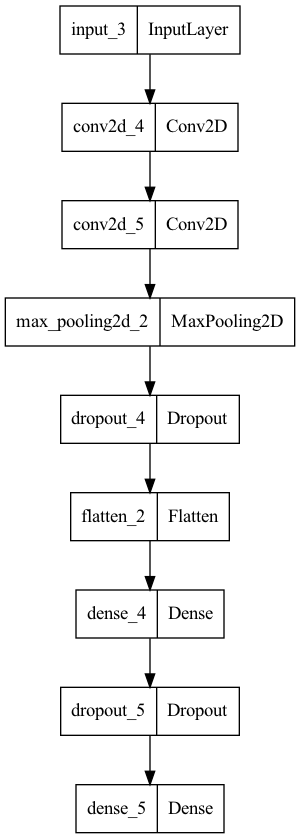

In [53]:
keras.utils.plot_model(model)

In [54]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 12)        60        
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 27, 24)        1176      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 24)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 24)        0         
                                                                 
 flatten_2 (Flatten)         (None, 4056)              0         
                                                           

### Compilación

Como estamos usando la codificación 1-de-K, necesitamos usar `categorical_crossentropy` como función de pérdida. Si usamos dígitos como etiquetas, la función adecuada es `sparse_categorical_crossentropy`.

También le decimos al modelo que controle la Precisión (pero podríamos proporcionar otras métricas aquí, como el recuerdo de cincos... `keras.metrics.Recall()`

In [62]:
model.compile(loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

***
**Juego**: ¿Pueden calcular el número de parámetros que tiene este modelo?

### Entrenamiento

El entrenamiento puede ser complicado y/o costoso, incluso para una red pequeña como ésta. 

Para acelerar el proceso, y comprobar que la red no está sobreajustada, añadiremos un paso adicional en el proceso de ajuste. Un _callback_ que puede detener el entrenamiento antes de tiempo si no se ve ninguna mejora en la pérdida de validación. 

Esto se implementa en `EarlyStopping`. Volveremos sobre esto la semana que viene.

In [63]:
early = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss',
                                      restore_best_weights=True)

En este caso, esperamos 15 épocas para ver una mejora. Si no se ve ninguna, el ajuste vuelve a los valores óptimos y se detiene el entrenamiento. Esto es _muy_ útil.

Sabemos que se ajusta al modelo, pero fíjate en los siguientes cambios:

1. La salida del método se almacena en una variable `ajuste` que contiene la evolución del proceso de traning.
2. Añadimos el argumento `validation_data` para definir qué conjunto de datos utilizar para la validación.
3. Incluimos un callback (podría haber una legión; ver `keras.callbacks` y [documentación](https://keras.io/api/callbacks/).

In [64]:
X_train2 = X_train.reshape(-1, 28, 28, 1)
X_test2 = X_test.reshape(-1, 28, 28, 1)

In [65]:
ajuste = model.fit(epochs=100, x=X_train2, y=t_train, 
                   validation_data=(X_test2, t_test), 
                   callbacks=[early,])

Epoch 1/100


2024-11-14 01:13:52.268642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1870/1875 [============================>.] - ETA: 0s - loss: 0.2119 - accuracy: 0.9359

2024-11-14 01:14:13.471430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 24s 11ms/step - loss: 0.2116 - accuracy: 0.9360 - val_loss: 0.0929 - val_accuracy: 0.9717
Epoch 2/100
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0888 - accuracy: 0.9736 - val_loss: 0.0638 - val_accuracy: 0.9802
Epoch 3/100
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0734 - accuracy: 0.9786 - val_loss: 0.0568 - val_accuracy: 0.9820
Epoch 4/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0651 - accuracy: 0.9814 - val_loss: 0.0542 - val_accuracy: 0.9831
Epoch 5/100
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0625 - accuracy: 0.9816 - val_loss: 0.0568 - val_accuracy: 0.9828
Epoch 6/100
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0610 - accuracy: 0.9821 - val_loss: 0.0626 - val_accuracy: 0.9823
Epoch 7/100
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0592 - accuracy: 0.9826 - val_loss: 0.0550 - val_

Nos gustaría ver un gráfico de la evolución del ajuste. De esto se trata la variable `ajuste`.

In [66]:
ajuste.history

{'loss': [0.21164776384830475,
  0.08879062533378601,
  0.07343356311321259,
  0.06513229012489319,
  0.06246697157621384,
  0.06098952889442444,
  0.0592455193400383,
  0.05757643282413483,
  0.05853357911109924,
  0.05651254206895828,
  0.053616713732481,
  0.059629909694194794,
  0.0561777763068676,
  0.05613544210791588,
  0.05844804644584656,
  0.056857191026210785,
  0.05778178572654724,
  0.05613246560096741,
  0.055320583283901215],
 'accuracy': [0.936033308506012,
  0.9735999703407288,
  0.9785666465759277,
  0.9813666939735413,
  0.9816333055496216,
  0.9821333289146423,
  0.9826333522796631,
  0.9832000136375427,
  0.9836000204086304,
  0.9840499758720398,
  0.9847999811172485,
  0.9834499955177307,
  0.9838500022888184,
  0.9841333627700806,
  0.9832666516304016,
  0.9842166900634766,
  0.9835666418075562,
  0.9847166538238525,
  0.9852166771888733],
 'val_loss': [0.09290662407875061,
  0.06378131359815598,
  0.056837297976017,
  0.05416182801127434,
  0.056825995445251465,

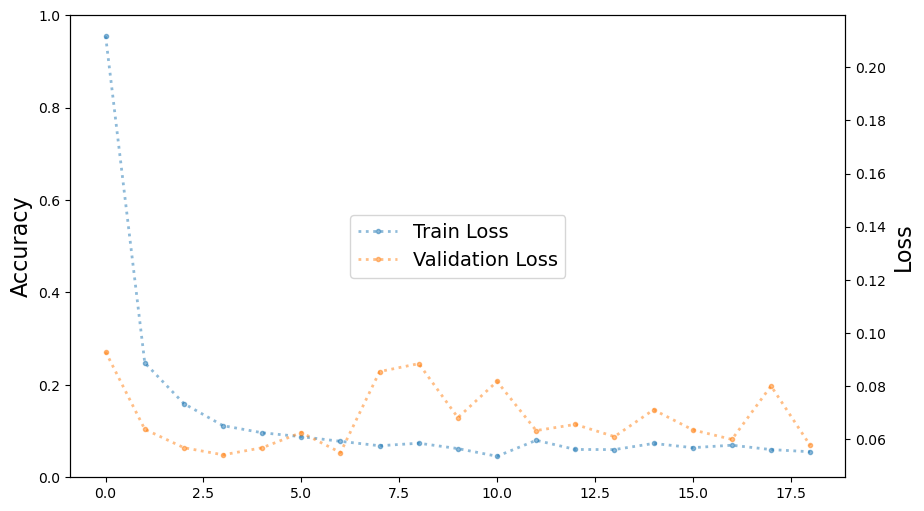

In [69]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

kw = {'marker': '.', 'lw': 2, 'alpha': 0.5}
# l0, = ax.plot(ajuste.history['accuracy'], label='Train Accuracy', **kw)
# l1, = ax.plot(ajuste.history['val_accuracy'], label='Validation Accuracy', **kw)

ax2 = ax.twinx()
ll0, = ax2.plot(ajuste.history['loss'], ls=':', color='C0', label='Train Loss', **kw)
ll1, = ax2.plot(ajuste.history['val_loss'], ls=':', color='C1', label='Validation Loss', **kw)

ax.set_ylabel('Accuracy', fontsize=16)
ax2.set_ylabel('Loss', fontsize=16)

ax.legend(handles=[ll0, ll1], loc='center', fontsize=14)
# plt.legend(loc=0)

### Análisis

Exploremos ahora un poco más los errores de la red. Para eso, trabajaremos con el conjunto de test (esto no es del todo correcto porque usamos el mismo conjunto para hacer la validación).

In [71]:
model.evaluate(X_test, t_test)

2024-11-14 02:15:34.306252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 0.0542 - accuracy: 0.9831


[0.05416182801127434, 0.9830999970436096]

Veamos con más detalle los casos en los que la red cometió errores

In [72]:
model.predict(X_test).shape

2024-11-14 02:15:39.535233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(10000, 10)

In [73]:
# Calcular las predicciones y encontrar los casos con error
y_test = np.argmax(model.predict(X_test), axis=1)

ierror = (y_test - t_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de validación'.format(np.sum(ierror)))

Hay 169 errores en el conjunto de validación


/var/folders/7v/d_f1zk9s1s368c_mndfk7vt00000gn/T/ipykernel_77122/3079651636.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_rows = np.int(n_images / n_columns)


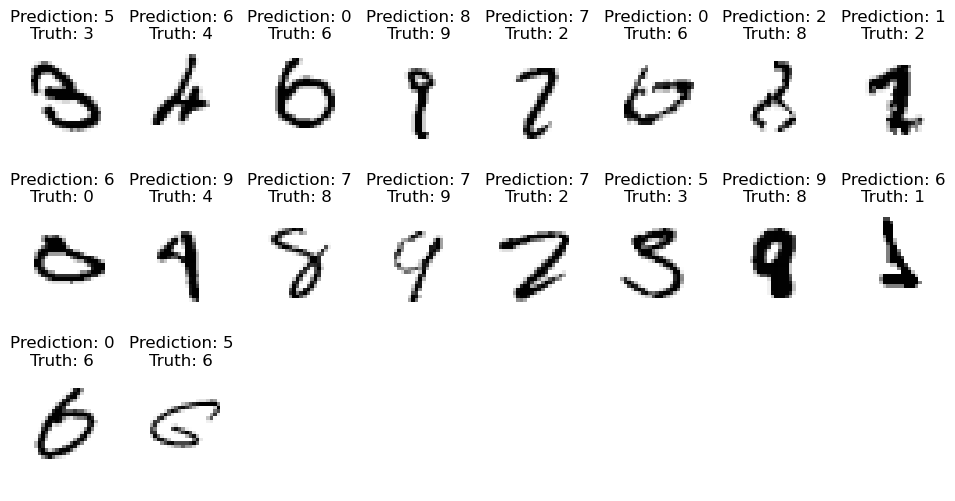

In [74]:
n_images = 18
n_columns = 8

n_rows = np.int(n_images / n_columns)

if n_images % n_columns != 0:
    n_rows += 1

fig, axs = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(12, 2*n_rows))

# Veamos algunos ejemplos de los datos en los que se equivocó
for i, ax in zip(range(n_images), axs.flatten()):
    ax.imshow(X_test[ierror][i], interpolation='None', cmap='binary')
    ax.set_title('Prediction: {}\nTruth: {}'.format(y_test[ierror][i], t_test[ierror][i]))

for ax in axs.flatten():
    ax.axis('off')

Bien, esto parece razonable, ¿verdad? Miren esos números. Algunos son realmente difíciles....

Veamos la distribución de probabilidades. Usa la probabilidad de la clase que fue elegida por la red, tanto en el caso de los errores como de los que no lo fueron.

In [75]:
pred_proba_all = np.max(model.predict(X_test), axis=1)

pred_proba = np.max(model.predict(X_test[~ierror]), axis=1)
pred_proba_err = np.max(model.predict(X_test[ierror]), axis=1)

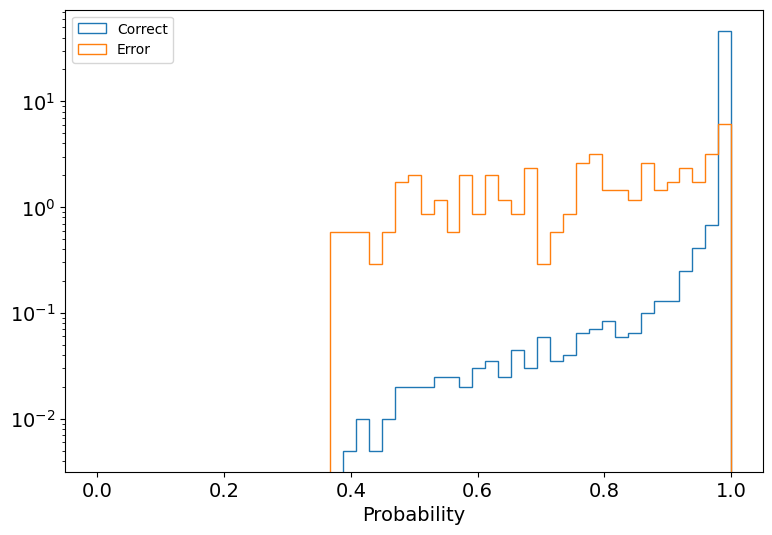

In [76]:
# Veamos la distribución
fig = plt.figure(figsize=(9,6))

bins = np.linspace(0, 1, 50)
plt.hist(pred_proba, bins=bins, histtype='step', label='Correct', density=True, log=True)
plt.hist(pred_proba_err, bins=bins, histtype='step', label='Error', density=True)

# Labels and ticks
plt.xlabel('Probability', size=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc=2)

Esto es bueno. La red parece estar menos segura cuando comete errores. Esto significa que podríamos ajustar un poco el umbral de decisión para mejorar el rendimiento.

Pero parece estar bastante segura de algunos casos en los que se equivoca. Vamos a verlos.

In [77]:
ii = (pred_proba_all > 0.95) * (y_test - t_test != 0)

print('Hay {} imágenes erróneamente clasificadas y con prbabilidad por encima del 95%'.format(sum(ii)))

Hay 34 imágenes erróneamente clasificadas y con prbabilidad por encima del 95%


/var/folders/7v/d_f1zk9s1s368c_mndfk7vt00000gn/T/ipykernel_77122/3964299344.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_rows = np.int(n_images / n_columns)


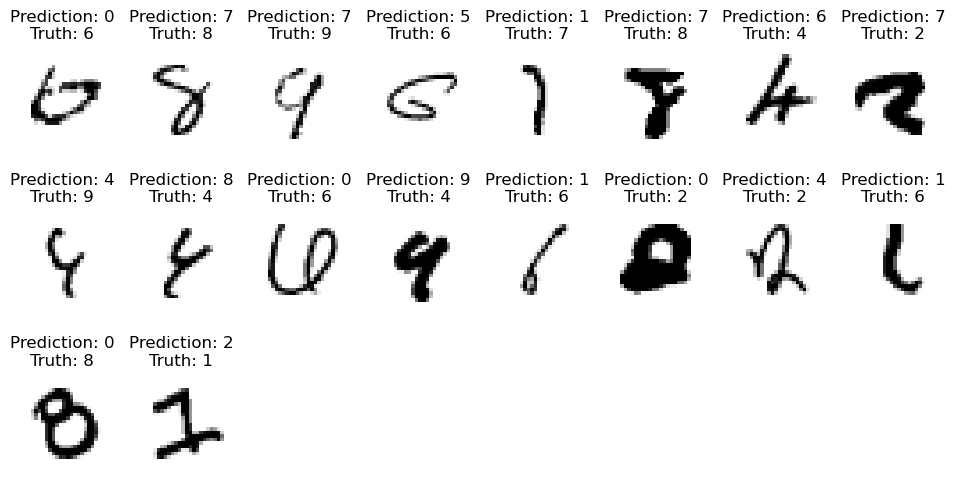

In [78]:
n_images = 18
n_columns = 8

n_rows = np.int(n_images / n_columns)

if n_images % n_columns != 0:
    n_rows += 1

fig, axs = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(12, 2*n_rows))
# Veamos algunos ejemplos de los datos en los que se equivocó

for i, ax in zip(range(n_images), axs.flatten()):
    ax.imshow(X_test[ii][i], interpolation='None', cmap='binary')
    ax.set_title('Prediction: {}\nTruth: {}'.format(y_test[ii][i], 
                                                    t_test[ii][i]))

for ax in axs.flatten():
    ax.axis('off')